# Proyek Klasifikasi Gambar: Pharmaceutical Drugs and Vitamins Synthetic Images
- **Nama:** Filza Rahma Muflihah
- **Email:** filzarahmamuflihah@gmail.com
- **ID Dicoding:** filza_rahma_muflihah

## Import Semua Packages/Library yang Digunakan

In [ ]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import random
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pathlib
from PIL import Image
from io import BytesIO
from google.colab import files  # <- pastikan kamu pakai Colab
import zipfile

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d vencerlanz09/pharmaceutical-drugs-and-vitamins-synthetic-images
!unzip /content/pharmaceutical-drugs-and-vitamins-synthetic-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00005001.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00005002.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00005003.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00005004.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00005005.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00005006.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00005007.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00005008.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00005009.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00005010.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00005011.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00005012.jpg  
 

In [ ]:
BASE_DIR = '/content/Drug Vision/Data Combined/'
os.listdir(BASE_DIR)

['Bioflu',
 'Fish Oil',
 'DayZinc',
 'Medicol',
 'Decolgen',
 'Neozep',
 'Alaxan',
 'Biogesic',
 'Kremil S',
 'Bactidol']

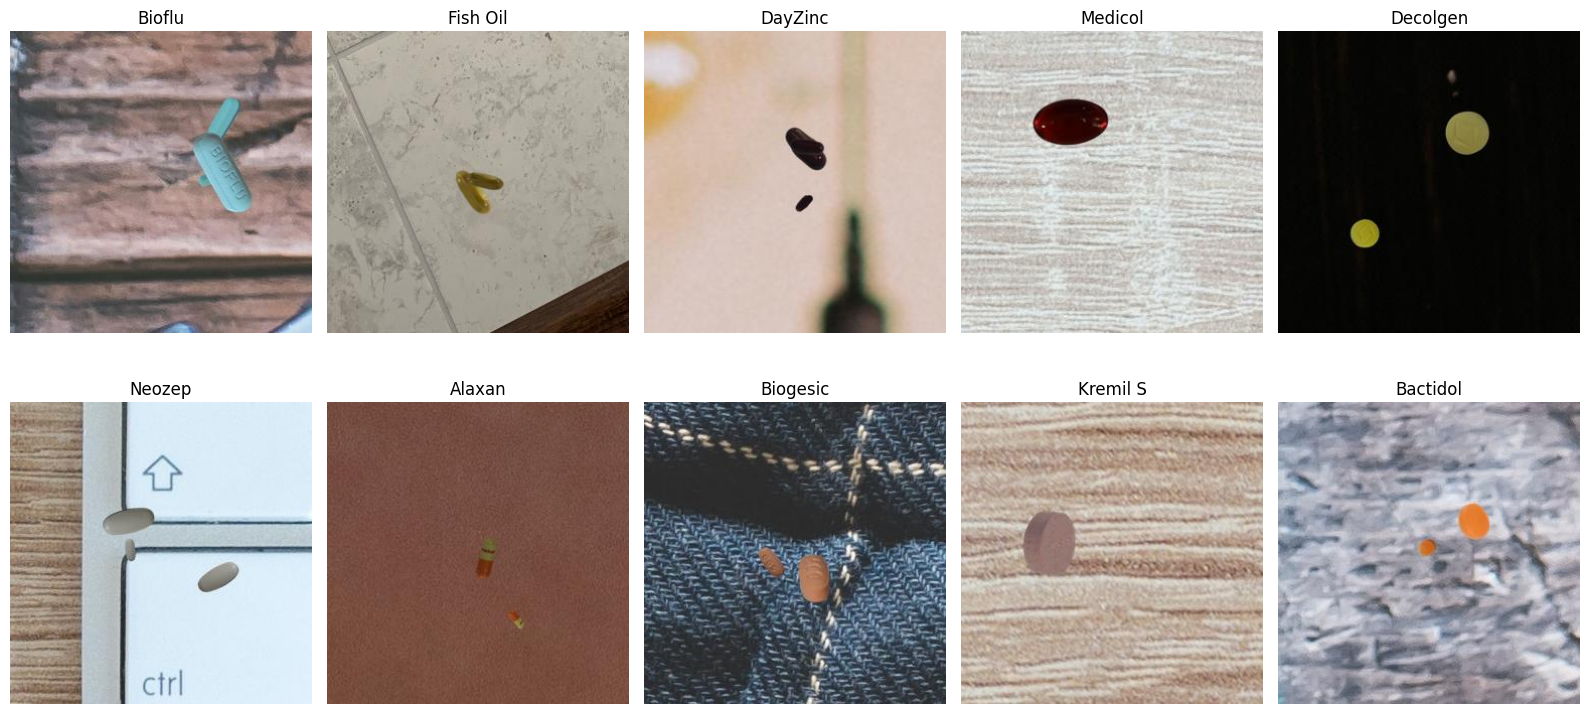

In [ ]:
# Mengambil label unik dan memastikan hanya 10 label yang diambil
label_names = [label for i, label in enumerate(os.listdir(BASE_DIR)) if i < 10]

plt.figure(figsize=(16, 8))

for i, label in enumerate(label_names):
    path = os.path.join(BASE_DIR, label)
    image_files = os.listdir(path)
    if image_files:  # Memastikan ada gambar di dalam direktori label
        random_image = random.choice(image_files)
        random_image_path = os.path.join(path, random_image)
        img = cv2.imread(random_image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Plot
        plt.subplot(2, 5, i + 1)  # 2 baris x 5 kolom untuk 10 gambar
        plt.imshow(tf.cast(img, tf.uint8))
        plt.title(label)
        plt.axis('off')
    else:
        print(f"Peringatan: Tidak ada gambar ditemukan di direktori '{label}'.")

plt.tight_layout()
plt.show()

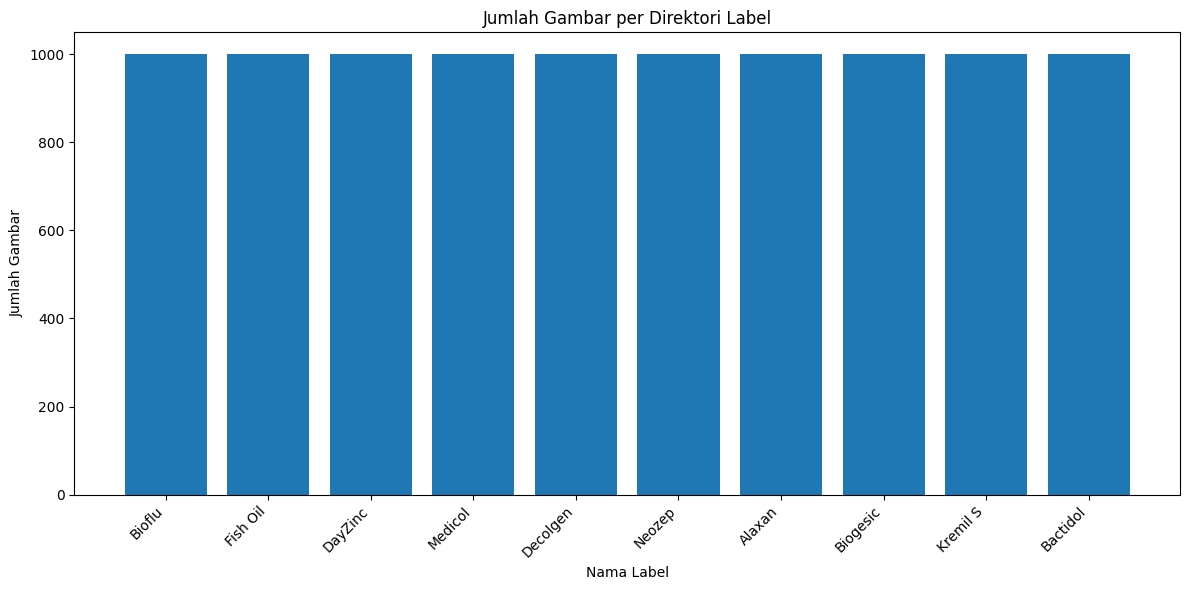

In [ ]:
label_counts = {}
for label in label_names:
    label_path = os.path.join(BASE_DIR, label)
    if os.path.isdir(label_path):  # Memastikan ini adalah direktori
        image_files = os.listdir(label_path)
        label_counts[label] = len(image_files)

# Membuat bar chart
plt.figure(figsize=(12, 6))
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel('Nama Label')
plt.ylabel('Jumlah Gambar')
plt.title('Jumlah Gambar per Direktori Label')
plt.xticks(rotation=45, ha='right')  # Rotasi label sumbu x agar tidak bertabrakan
plt.tight_layout()

### Data Splitting

In [ ]:
# Path ke folder dataset awal
folder_base = BASE_DIR

# Path folder output
output_base = '/content/Drug Vision/Data Split'
train_dir = os.path.join(output_base, 'train')
val_dir = os.path.join(output_base, 'val')
test_dir = os.path.join(output_base, 'test')

# Membuat folder output jika belum ada
for directory in [output_base, train_dir, val_dir, test_dir]:
    os.makedirs(directory, exist_ok=True)

print("Mulai proses split dataset...\n")

# Untuk mencatat report
report = {}

# Untuk setiap kelas
for class_name in os.listdir(folder_base):
    class_path = os.path.join(folder_base, class_name)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        random.shuffle(images)

        n_total = len(images)
        n_train = int(0.7 * n_total)
        n_val = int(0.2 * n_total)
        n_test = n_total - n_train - n_val  # sisanya ke test

        train_imgs = images[:n_train]
        val_imgs = images[n_train:n_train+n_val]
        test_imgs = images[n_train+n_val:]  # <<< PERBAIKI DI SINI!!

        report[class_name] = {'train': len(train_imgs), 'val': len(val_imgs), 'test': len(test_imgs)}

        # Buat folder kelas di masing-masing split
        for split_name, split_imgs in [('train', train_imgs), ('val', val_imgs), ('test', test_imgs)]:
            split_class_dir = os.path.join(output_base, split_name, class_name)
            os.makedirs(split_class_dir, exist_ok=True)
            for img_name in split_imgs:
                src_path = os.path.join(class_path, img_name)
                dst_path = os.path.join(split_class_dir, img_name)
                shutil.copy2(src_path, dst_path)

print("Selesai membagi dataset!\n")

# Cetak laporan
print("Ringkasan jumlah file per kelas:")
for class_name, splits in report.items():
    print(f"- {class_name}: Train={splits['train']}, Val={splits['val']}, Test={splits['test']}")


Mulai proses split dataset...

Selesai membagi dataset!

Ringkasan jumlah file per kelas:
- Bioflu: Train=700, Val=200, Test=100
- Fish Oil: Train=700, Val=200, Test=100
- DayZinc: Train=700, Val=200, Test=100
- Medicol: Train=700, Val=200, Test=100
- Decolgen: Train=700, Val=200, Test=100
- Neozep: Train=700, Val=200, Test=100
- Alaxan: Train=700, Val=200, Test=100
- Biogesic: Train=700, Val=200, Test=100
- Kremil S: Train=700, Val=200, Test=100
- Bactidol: Train=700, Val=200, Test=100


## Image Augmentation

In [ ]:
# Image Data Generator
train_datagen = ImageDataGenerator(rescale=1/255.,

                                   #augmentasi gambar
                                   rotation_range=40,                                                           #rotasi gambar hingga 40 derajat
                                   width_shift_range=0.2,                                                       #pelebaran gambar hingga 0.2 kali lebar asal
                                   height_shift_range=0.2,                                                      #peninggian gambar hingga 0.2 kali tinggi asal
                                   shear_range=0.15,                                                            #pemangkasan gambar hingga 0.15 kali ukuran asal
                                   zoom_range=0.15,                                                             #zoom gambar hingga 0.15 kali ukuran asal
                                   brightness_range=(0.2, 0.8),                                                 #mengatur kecerahan gambar
                                   horizontal_flip=True,                                                        #putar balik gambar secara horizontal
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)

Found 7000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


## Modelling

In [22]:
# Load base model MobileNet tanpa top layer (include_top=False)
base_model = tf.keras.applications.MobileNet(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Buat model dengan ResNet50 + custom classifier di atasnya
model = tf.keras.models.Sequential([
    base_model,

    # feature extraction layer
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # reshape feature map
    tf.keras.layers.GlobalAveragePooling2D(),

    # dropout regularization
    tf.keras.layers.Dropout(0.2),

    # fully connected layer
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 32)       │       294,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,526,570 (13.45 MB)

 Trainable params: 3,504,682 (13.37 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [23]:
# Inisiasi Callback
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.95 and logs.get('val_accuracy') >0.95):
            print("\nReached 95% validation accuracy, Stop training!")
            self.model.stop_training = True

CALLBACK = MyCallback()

In [24]:
# Training Model
history = model.fit(train_generator,
                    epochs=100,
                    batch_size=64,
                    validation_data=val_generator,
                    callbacks=[CALLBACK])

Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 136s 507ms/step - accuracy: 0.4422 - loss: 1.5850 - val_accuracy: 0.6115 - val_loss: 1.4662
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 99s 451ms/step - accuracy: 0.7947 - loss: 0.6040 - val_accuracy: 0.6620 - val_loss: 2.9354
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 99s 452ms/step - accuracy: 0.8537 - loss: 0.4745 - val_accuracy: 0.9070 - val_loss: 0.3861
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 98s 446ms/step - accuracy: 0.9042 - loss: 0.2991 - val_accuracy: 0.9820 - val_loss: 0.0803
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 98s 448ms/step - accuracy: 0.9316 - loss: 0.2316 - val_accuracy: 0.9540 - val_loss: 0.1692
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 151s 489ms/step - accuracy: 0.9358 - loss: 0.2356 - val_accuracy: 0.9785 - val_loss: 0.0898
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 100s 455ms/step - accuracy: 0.9504 - loss: 0.1672 - val_accuracy: 0.9345 - val_loss: 0.2397
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 98s 449ms/step - accuracy: 0.954

## Evaluasi dan Visualisasi

## Visualisasi Akurasi dan Loss

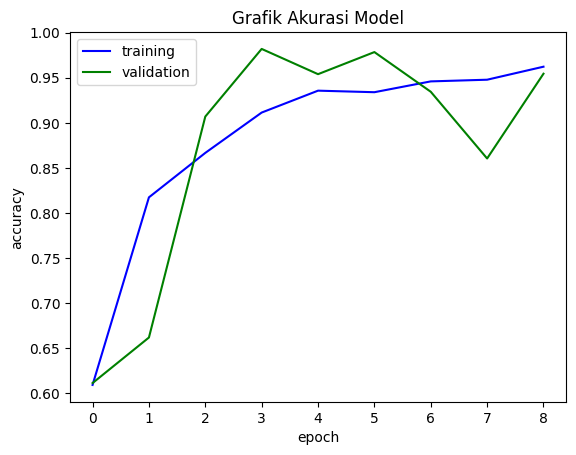

<Figure size 640x480 with 0 Axes>

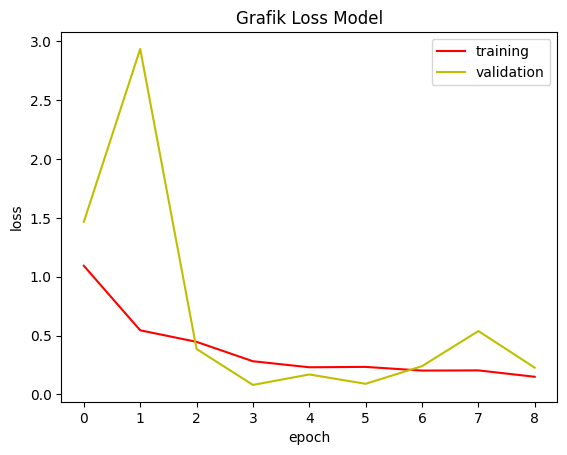

<Figure size 640x480 with 0 Axes>

In [26]:
acc = history.history['accuracy']               #Nilai akurasi training
val_acc = history.history['val_accuracy']       #Nilai akurasi validation

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='training')
plt.plot(epochs, val_acc, 'g', label='validation')
plt.title('Grafik Akurasi Model')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

loss = history.history['loss']                  #Nilai loss training
val_loss = history.history['val_loss']          #Nilai loss validation

plt.plot(epochs, loss, 'r', label='training')
plt.plot(epochs, val_loss, 'y', label='validation')
plt.title('Grafik Loss Model')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc=0)
plt.figure()
plt.show()

## Evaluasi Model pada Unseen Data (Test Set)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step


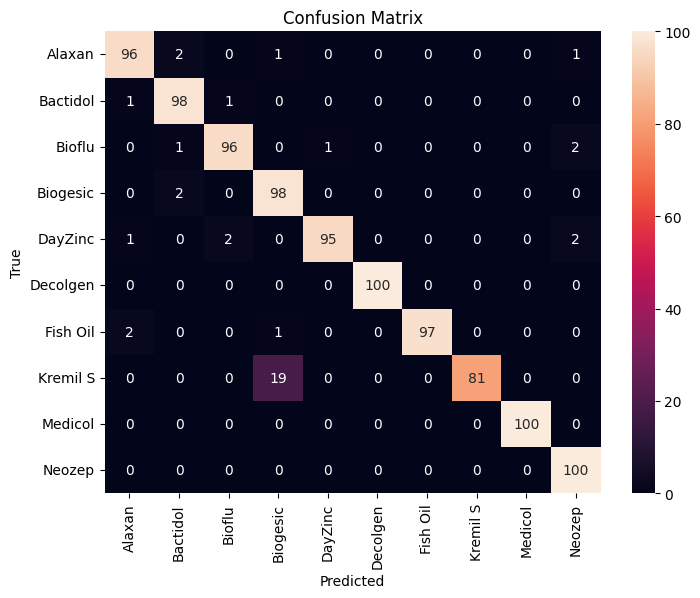

In [27]:
# Prediksi semua data di test set
pred_probs = model.predict(test_generator)
pred_classes = np.argmax(pred_probs, axis=1)  # ambil index kelas dengan prob tertinggi

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [28]:
# Classification report
report = classification_report(true_classes, pred_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

      Alaxan       0.96      0.96      0.96       100
    Bactidol       0.95      0.98      0.97       100
      Bioflu       0.97      0.96      0.96       100
    Biogesic       0.82      0.98      0.89       100
     DayZinc       0.99      0.95      0.97       100
    Decolgen       1.00      1.00      1.00       100
    Fish Oil       1.00      0.97      0.98       100
    Kremil S       1.00      0.81      0.90       100
     Medicol       1.00      1.00      1.00       100
      Neozep       0.95      1.00      0.98       100

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000



## Eksperimen Prediksi Model terhadap 10 Sampel Gambar

In [41]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [48]:
# Parameter
img_height = 224
img_width = 224

# Ambil nama label (kelas)
class_names = sorted(os.listdir(test_dir))

selected_images = []
selected_labels = []

# Untuk setiap kelas, ambil satu gambar
for idx, class_name in enumerate(class_names):
    class_path = os.path.join(test_dir, class_name)
    image_names = os.listdir(class_path)

    # Ambil 1 file gambar
    img_path = os.path.join(class_path, image_names[0])

    # Load gambar
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0

    selected_images.append(img_array)
    selected_labels.append(idx)

# Konversi jadi numpy array
selected_images = np.array(selected_images)
selected_labels = np.array(selected_labels)

print(f"Selected images shape: {selected_images.shape}")
print(f"Selected labels: {selected_labels}")


Selected images shape: (10, 224, 224, 3)
Selected labels: [0 1 2 3 4 5 6 7 8 9]


In [49]:
# Model probabilitas
probability_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Softmax()
])

# Prediksi untuk 10 gambar terpilih
predictions = probability_model.predict(selected_images)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


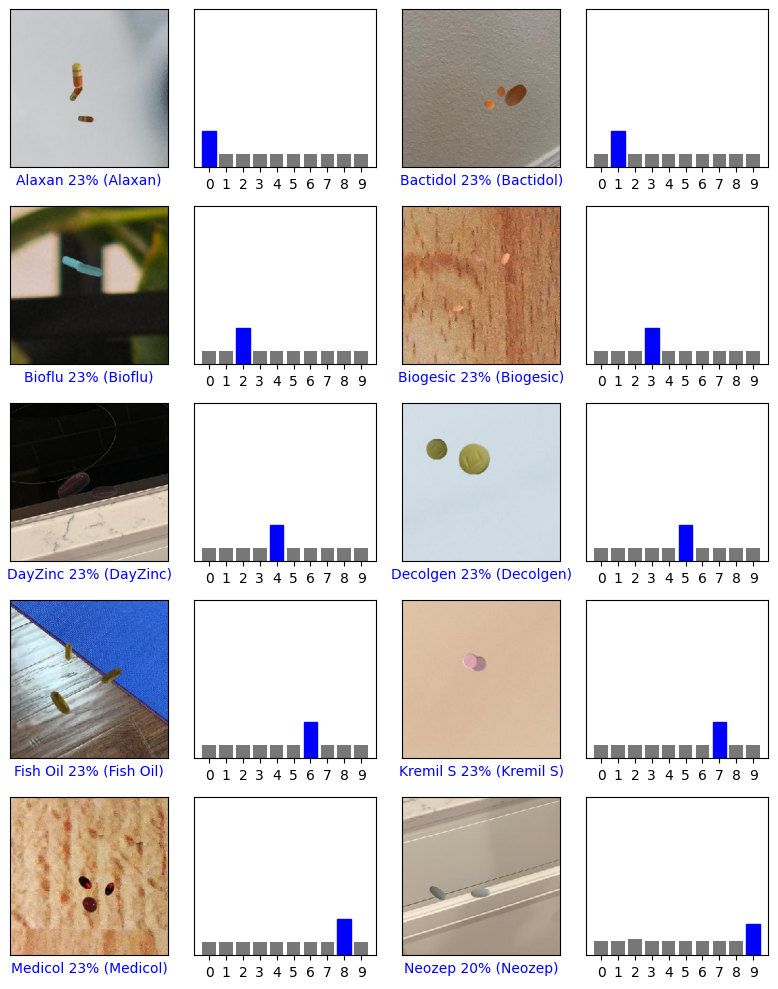

In [50]:
num_rows = 5
num_cols = 2
num_images = num_rows * num_cols

plt.figure(figsize=(2*2*num_cols, 2*num_rows))  # Ukuran canvas

for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)   # Posisi gambar
    plot_image(0, predictions[i], [selected_labels[i]], [selected_images[i]])

    plt.subplot(num_rows, 2*num_cols, 2*i+2)   # Posisi bar chart
    plot_value_array(0, predictions[i], [selected_labels[i]])

plt.tight_layout()
plt.show()


## Konversi Model

## Versi SavedModel

In [51]:
# konversi model ke format SavedModel
save_path = 'saved_model/'
tf.saved_model.save(model, save_path)

## Versi TFJS

In [52]:
# Install tensorflowjs
!pip install tensorflowjs

# Konversi savedmodel ke tensorflowjs
!tensorflowjs_converter --input_format=tf_saved_model \
    saved_model \
    tfjs_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
2025-04-28 15:17:54.710282: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745853474.730711   34122 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:174

## Versi TF Lite

In [53]:
# Konversi dari folder yang BENAR
export_dir = 'saved_model'
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

# Simpan file .tflite ke dalam folder tflite/
output_dir = pathlib.Path('tflite')
output_dir.mkdir(exist_ok=True)

tflite_model_file = output_dir / 'model.tflite'
tflite_model_file.write_bytes(tflite_model)

# Simpan label
index_to_label = {v: k for k, v in train_generator.class_indices.items()}
label_list = [index_to_label[i] for i in range(len(index_to_label))]
with open('tflite/label.txt', 'w') as f:
    for label in label_list:
        f.write(f"{label}\n")

## Inference (Optional)

Saving 00000033.jpg to 00000033.jpg
🖼️ Gambar yang diupload: 00000033.jpg


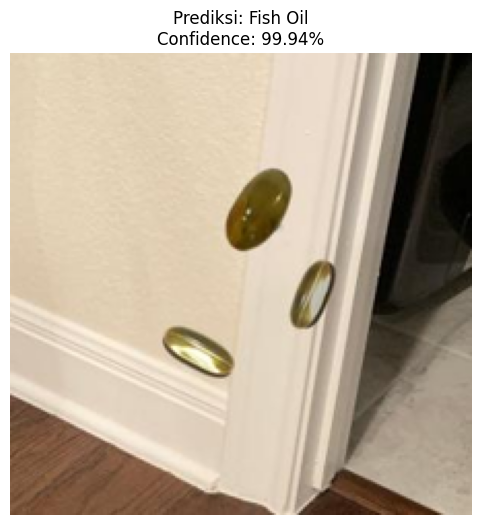

✅ Prediksi     : Fish Oil
📊 Confidence   : 99.94%


In [56]:
# Load model ---
model_path = './saved_model'  # Ganti path SavedModel kamu
loaded_model = tf.saved_model.load(model_path)
infer_fn = loaded_model.signatures['serving_default']

# Fungsi load dan preprocess gambar ---
def load_and_preprocess_uploaded_image(uploaded_file, target_size=(224, 224)):
    img = Image.open(uploaded_file).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img, dtype=np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # shape: [1, height, width, 3]
    return img, tf.constant(img_array)

# Upload gambar ---
uploaded = files.upload()

# Ambil nama file yang diupload
for file_name in uploaded.keys():
    print(f"🖼️ Gambar yang diupload: {file_name}")
    uploaded_file = BytesIO(uploaded[file_name])

# Load dan preprocess gambar dari upload
original_img, input_tensor = load_and_preprocess_uploaded_image(uploaded_file)

# Inference
input_key = list(infer_fn.structured_input_signature[1].keys())[0]
predictions = infer_fn(**{input_key: input_tensor})
output_tensor = list(predictions.values())[0]
output_array = output_tensor.numpy()[0]
predicted_index = np.argmax(output_array)
confidence = np.max(output_array)


predicted_label = class_names[predicted_index]

# Tampilkan gambar dan hasil
plt.figure(figsize=(6, 6))
plt.imshow(original_img)
plt.axis('off')
plt.title(f"Prediksi: {predicted_label}\nConfidence: {confidence*100:.2f}%")
plt.show()

# Print hasil
print(f"✅ Prediksi     : {predicted_label}")
print(f"📊 Confidence   : {confidence:.2%}")


# Save Requirements and Download Files

In [57]:
!pip freeze > '/content/requirements.txt'

In [58]:
# List of folders/files you want to exclude (relative to /content)
skip_list = [
    'Drug Vision',
    'ImageClassesCombinedWithCOCOAnnotations',
    'sample_data',
    'kaggle.json',
    'pharmaceutical-drugs-and-vitamins-synthetic-images.zip',
]

# Output zip filename
zip_filename = '/content/pharmacetical-drug-recognition.zip'

# Create a zip file
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk('/content'):
        # Skip any folder in the skip list
        if any(skip_item in root for skip_item in skip_list):
            continue
        for file in files:
            file_path = os.path.join(root, file)
            # Also check individual files before adding
            rel_path = os.path.relpath(file_path, '/content')
            if any(skip_item == rel_path or skip_item in rel_path for skip_item in skip_list):
                continue
            # Write file into the zip (preserve folder structure relative to /content)
            zipf.write(file_path, rel_path)

# Download the resulting zip
files.download(zip_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>